# Training and Tuning Deep MLP on the MNIST dataset.

In [1]:
import sys

assert sys.version_info >= (3, 7)
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import Perceptron

2024-07-03 13:47:13.531065: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-03 13:47:13.531209: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-03 13:47:13.732268: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Loading the Dataset


In [2]:
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [3]:
X_train_full.shape

(60000, 28, 28)

In [4]:
# Each pixel intesity is presented as a byte
X_train_full.dtype

dtype('uint8')

In [5]:
# We will split the full traing set into a validation set and a (smaller) training set.
# We scale the pixel intensitie down to the 0 - 1 range and convert them to floats by dividing by 255.

X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

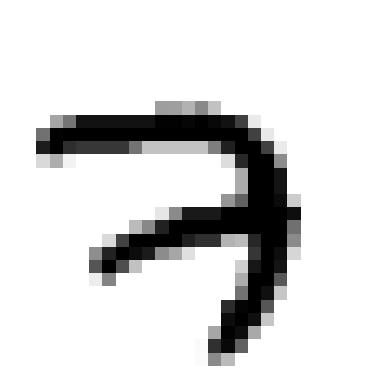

In [6]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

In [7]:
# The labels correspond to the dataset.
y_train

array([7, 3, 4, ..., 5, 6, 8], dtype=uint8)

In [8]:
# The validation set now contains 5,000 images and the test set contains 10,000 images
X_valid.shape

(5000, 28, 28)

In [9]:
X_test.shape

(10000, 28, 28)

## Sample of the images in the dataset

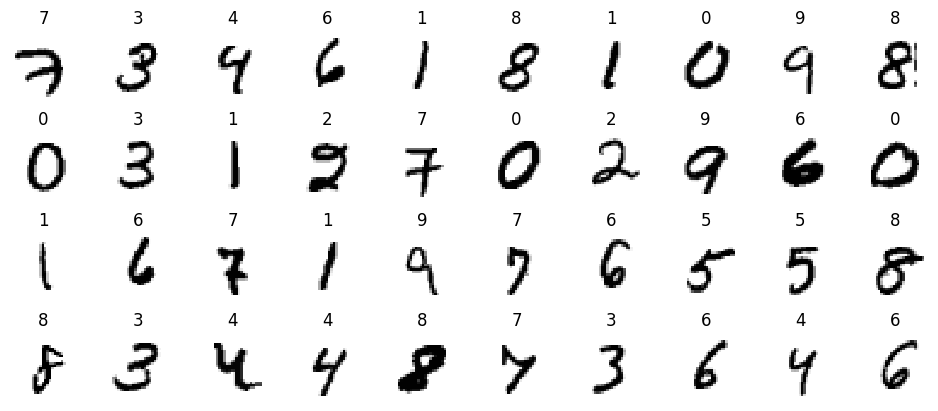

In [10]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(y_train[index])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

## Building a Dense Network

- A simple dense network to find the optimal learning rate.
- We'll need a callback to grow the learning rate at each iteration, it will also record the learning rate and loss at each iteration.

In [11]:
K = tf.keras.backend

class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        current_lr = self.model.optimizer.get_config()['learning_rate']
        self.rates.append(current_lr)
        self.losses.append(logs["loss"])
        new_lr = current_lr * self.factor
        self.model.optimizer.learning_rate = new_lr

In [12]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10 ,activation="softmax")
])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [14]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
expon_lr = ExponentialLearningRate(factor=1.005)

In [15]:
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[expon_lr])

1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.4886 - loss: nan - val_accuracy: 0.0958 - val_loss: nan


Text(0, 0.5, 'Loss')

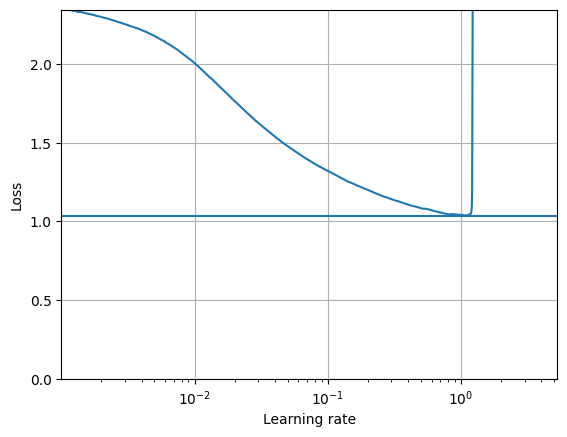

In [16]:
plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")

In [17]:
# Loss shoots up violently past 6e-1
# Next we'll try using half at 3e-1

tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [18]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [19]:
optimizer = tf.keras.optimizers.SGD(learning_rate=3e-1)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [20]:
from pathlib import Path

run_index = 1 # increment this at every run
run_logdir = Path() / "my_mnist_logs" / "run_{:03d}".format(run_index)
run_logdir

PosixPath('my_mnist_logs/run_001')

In [21]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_mnist_model.keras", save_best_only=True)
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)

history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

Epoch 1/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8715 - loss: 0.4036 - val_accuracy: 0.9670 - val_loss: 0.1098
Epoch 2/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9701 - loss: 0.0994 - val_accuracy: 0.9750 - val_loss: 0.0804
Epoch 3/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9806 - loss: 0.0642 - val_accuracy: 0.9742 - val_loss: 0.0905
Epoch 4/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9867 - loss: 0.0432 - val_accuracy: 0.9796 - val_loss: 0.0834
Epoch 5/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9898 - loss: 0.0328 - val_accuracy: 0.9730 - val_loss: 0.0959
Epoch 6/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9915 - loss: 0.0272 - val_accuracy: 0.9770 - val_loss: 0.1005
Epoch 7/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9924 - loss: 0.0241 - val_accuracy: 0.9794 - val_loss: 0.0814
Epoch 8/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9940 - loss: 0

In [22]:
model = tf.keras.models.load_model("my_mnist_model.keras") # roll back to best model.
model.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9669 - loss: 0.1074


[0.08725562691688538, 0.9714999794960022]

In [23]:
%load_ext tensorboard

In [24]:
%tensorboard --logdir=./my_mnist_logs

## Optimizing the Neural Net Using Keras Tuner.

In [25]:
def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=[28, 28]))
    
    # Tune the number of units in the first Dense layer
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    model.add(keras.layers.Dense(units=hp_units, activation='relu'))
    
    # Tune the number of Dense layers and their units
    for i in range(hp.Int('num_layers', 1, 4)):
        # Tune number of units separately for each layer
        units = hp.Int(f'units_{i}', min_value=32, max_value=512, step=32)
        
        # Tune dropout rate
        dropout_rate = hp.Float(f'dropout_{i}', min_value=0.0, max_value=0.5, step=0.1)
        
        # Tune activation function
        activation = hp.Choice(f'activation_{i}', values=['relu', 'tanh', 'selu'])
        
        model.add(keras.layers.Dense(units=units, activation=activation))
        model.add(keras.layers.Dropout(rate=dropout_rate))
    
    model.add(keras.layers.Dense(10, activation='softmax'))
    
    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    
    # Tune the choice of optimizer
    optimizer_choice = hp.Choice('optimizer', values=['adam', 'sgd', 'rmsprop'])
    if optimizer_choice == 'adam':
        optimizer = keras.optimizers.Adam(learning_rate=hp_learning_rate)
    elif optimizer_choice == 'sgd':
        optimizer = keras.optimizers.SGD(learning_rate=hp_learning_rate)
    else:
        optimizer = keras.optimizers.RMSprop(learning_rate=hp_learning_rate)
    
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [26]:
from tensorflow import keras
import keras_tuner as kt


tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=4,
                     factor=3,
                     directory='my_dir',
                     project_name='mnist_tuning')

# Define callbacks
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tensorboard_cb = tf.keras.callbacks.TensorBoard('mnist_tb_logs')

/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [27]:
# Perform the hyperparameter search
tuner.search(X_train, y_train,
             epochs=4,
             validation_split=0.2,
             callbacks=[stop_early, tensorboard_cb])

Trial 10 Complete [00h 00m 51s]
val_accuracy: 0.9690909385681152

Best val_accuracy So Far: 0.9712727069854736
Total elapsed time: 00h 05m 04s


In [28]:
# Get the best model and hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

In [29]:
# Train the best model
history = best_model.fit(X_train, y_train, 
                         epochs=10,
                         validation_split=0.2,
                         callbacks=[stop_early, tensorboard_cb])

Epoch 1/10
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.7690 - loss: 0.7478 - val_accuracy: 0.9485 - val_loss: 0.1737
Epoch 2/10
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9472 - loss: 0.1759 - val_accuracy: 0.9589 - val_loss: 0.1357
Epoch 3/10
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9650 - loss: 0.1179 - val_accuracy: 0.9671 - val_loss: 0.1107
Epoch 4/10
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9752 - loss: 0.0836 - val_accuracy: 0.9725 - val_loss: 0.0961
Epoch 5/10
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9802 - loss: 0.0665 - val_accuracy: 0.9718 - val_loss: 0.0992
Epoch 6/10
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9840 - loss: 0.0503 - val_accuracy: 0.9729 - val_loss: 0.0973
Epoch 7/10
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9880 - loss: 0.0386 - val_accuracy: 0.9758 - val_loss: 0.0930
Epoch 8/10
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9903 - loss: 0

In [30]:
test_loss, test_acc = best_model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9736 - loss: 0.1071
Test accuracy: 0.9769999980926514
